In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

In [2]:
# --- 1. IMPORT THE ENVIRONMENT ---
# We use a trick to import the other .ipynb file as a library
import import_ipynb 
import RYU_ENV as env_module

print("✅ Successfully connected to Ryu_Environment_Setup!")

🎬 STARTING CALIBRATION TEST (10 Seconds)...
   Target Topology: sat2iptopo.py (Core 1-4, Edge 7+)
-----------------------------------------------------
✅ Environment Loaded.

⏱️  [Time 1] Processing Traffic...
   🌊 Network Status:
      Edge Switch 7 (Host 0): 88.7% on Uplink 1 | 76.8% on Uplink 2
      Path A (Cores 1+2):     163.0% Load
      Path B (Cores 3+4):     152.8% Load

⏱️  [Time 2] Processing Traffic...
   🌊 Network Status:
      Edge Switch 7 (Host 0): 36.7% on Uplink 1 | 19.5% on Uplink 2
      Path A (Cores 1+2):     137.1% Load
      Path B (Cores 3+4):     92.2% Load

⏱️  [Time 3] Processing Traffic...
   🌊 Network Status:
      Edge Switch 7 (Host 0): 31.4% on Uplink 1 | 6.2% on Uplink 2
      Path A (Cores 1+2):     98.0% Load
      Path B (Cores 3+4):     28.8% Load

⏱️  [Time 4] Processing Traffic...
   🌊 Network Status:
      Edge Switch 7 (Host 0): 8.6% on Uplink 1 | 59.4% on Uplink 2
      Path A (Cores 1+2):     53.9% Load
      Path B (Cores 3+4):     120.2% L

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
# 🛠️ FIX: Use standard text-based progress bar to avoid crash
from tqdm import tqdm 
# ---------------------------------------------------------

# --- 0. ENSURE ENVIRONMENT IS LOADED ---
try:
    import RYU_ENV as env_module
    print("✅ Detected 'env_module'.")
except ImportError:
    print("⚠️ 'RYU_ENV' module not found. Make sure you ran the import cell!")

# --- 1. DQN COMPONENTS (UNCHANGED LOGIC) ---

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    """Prioritized Experience Replay with capacity management"""
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
    
    def push(self, *args):
        """Store a transition with initial high priority"""
        self.memory.append(Transition(*args))
        # New experiences get max priority to ensure they're sampled
        max_priority = max(self.priorities) if self.priorities else 1.0
        self.priorities.append(max_priority)
    
    def sample(self, batch_size, alpha=0.6):
        """Sample with priority weighting"""
        if len(self.memory) < batch_size: return None
        
        priorities = np.array(self.priorities)
        probs = priorities ** alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.memory), batch_size, p=probs, replace=False)
        samples = [self.memory[idx] for idx in indices]
        
        return samples, indices
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors"""
        for idx, error in zip(indices, td_errors):
            self.priorities[idx] = abs(error) + 1e-5
    
    def __len__(self):
        return len(self.memory)


class DQN_Network(nn.Module):
    """
    Deep Q-Network with Dueling Architecture for better value estimation.
    """
    def __init__(self, state_dim=20, action_dim=16, hidden_dims=[128, 256, 128]):
        super(DQN_Network, self).__init__()
        
        # Shared feature extraction
        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.LayerNorm(hidden_dims[0]),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.LayerNorm(hidden_dims[1]),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.LayerNorm(hidden_dims[2])
        )
        
        # Value Stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[2], 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Advantage Stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[2], 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        return value + (advantages - advantages.mean(dim=1, keepdim=True))


class DQN_Agent:
    """
    DQN Agent with advanced features: Double DQN, Dueling Networks, PER.
    """
    def __init__(self, state_dim=20, action_dim=16, device="cpu"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        
        # Networks
        self.policy_net = DQN_Network(state_dim, action_dim).to(self.device)
        self.target_net = DQN_Network(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Training Params
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.0005)
        self.loss_fn = nn.SmoothL1Loss()
        self.memory = ReplayMemory(10000)
        
        # Hyperparameters
        self.gamma = 0.95
        self.batch_size = 64
        self.target_update_freq = 10
        self.epsilon = 1.0
        self.epsilon_end = 0.05
        self.epsilon_decay = 0.98
        
        # Metrics
        self.training_step = 0
        self.episode_rewards = []

    def select_action(self, state, evaluation=False):
        if evaluation:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                return self.policy_net(state_t).argmax().item()
        
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                return self.policy_net(state_t).argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def compute_reward(self, util_dict, lat_dict):
        """Your Custom 'Cliff' Reward Logic"""
        all_utils = []
        # Flatten stats
        for sw in range(1, 5): 
            for p in range(1, 5): all_utils.append(util_dict[sw][p])
        for sw in [7, 8, 11, 12, 15, 16, 19, 20]:
            for p in [1, 2]: all_utils.append(util_dict[sw][p])
        
        all_utils = np.array(all_utils)
        reward = 10.0
        
        # 1. Cliff Penalty
        congested = all_utils > 100.0 # Assuming 100 Mbps limit
        if congested.any():
            overload = all_utils[congested] - 100.0
            reward -= 20.0 * overload.sum()
        else:
            reward += 15.0
            
        # 2. Efficiency Bonus (<80%)
        if all_utils.max() < 80.0: reward += 10.0
        
        # 3. Load Variance (Balance)
        reward -= 5.0 * all_utils.std()
        
        return reward

    def train_step(self):
        if len(self.memory) < self.batch_size: return None
        
        # Prioritized Sampling
        sample = self.memory.sample(self.batch_size)
        if sample is None: return None
        transitions, indices = sample
        batch = Transition(*zip(*transitions))

        # Tensors
        state_b = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action_b = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        reward_b = torch.FloatTensor(batch.reward).to(self.device)
        next_state_b = torch.FloatTensor(np.array(batch.next_state)).to(self.device)
        done_b = torch.FloatTensor(batch.done).to(self.device)

        # Double DQN Logic
        curr_q = self.policy_net(state_b).gather(1, action_b).squeeze()
        with torch.no_grad():
            next_actions = self.policy_net(next_state_b).argmax(1, keepdim=True)
            next_q = self.target_net(next_state_b).gather(1, next_actions).squeeze()
            target_q = reward_b + (1 - done_b) * self.gamma * next_q

        # Optimization
        loss = self.loss_fn(curr_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update Priorities
        td_errors = (curr_q - target_q).detach().cpu().numpy()
        self.memory.update_priorities(indices, td_errors)
        
        return loss.item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def save_model(self, filepath):
        torch.save(self.policy_net.state_dict(), filepath)
        print(f"💾 Model saved to {filepath}")


# --- 2. HELPER FUNCTIONS ---

def get_state_from_environment(env):
    """Normalize Utilizations to [0, 1] range"""
    util, _ = env.get_stats()
    state = []
    for sw in range(1, 5):
        for p in range(1, 5): state.append(util[sw][p] / 100.0)
    for sw in [7, 8, 11, 12, 15, 16, 19, 20]:
        for p in [1, 2]: state.append(util[sw][p] / 100.0)
    return np.array(state, dtype=np.float32)

def action_to_switch_port(action_id):
    switches = [7, 8, 11, 12, 15, 16, 19, 20]
    return switches[action_id // 2], (action_id % 2) + 1


def train_dqn(env, agent, num_episodes=200, max_steps_per_episode=100, save_path="models/dqn_sdn_model.pth"):
    print("\n" + "="*60)
    print("🚀 TRAINING DQN AGENT FOR SDN TRAFFIC OPTIMIZATION")
    print("="*60)
    
    best_avg_reward = -np.inf
    recent_rewards = deque(maxlen=100)
    
    # Using standard tqdm to prevent crash
    for episode in tqdm(range(num_episodes), desc="Training"):
        state = get_state_from_environment(env)
        episode_reward = 0
        episode_loss = []
        
        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            sw, port = action_to_switch_port(action)
            env.mod_flow(sw, port)
            
            env.tick()
            next_state = get_state_from_environment(env)
            util, lat = env.get_stats()
            reward = agent.compute_reward(util, lat)
            
            done = (step == max_steps_per_episode - 1)
            agent.store_transition(state, action, reward, next_state, done)
            loss = agent.train_step()
            if loss: episode_loss.append(loss)
            
            state = next_state
            episode_reward += reward
        
        agent.decay_epsilon()
        if episode % agent.target_update_freq == 0:
            agent.update_target_network()
            
        recent_rewards.append(episode_reward)
        avg_recent = np.mean(recent_rewards)
        
        if episode % 10 == 0:
            avg_loss = np.mean(episode_loss) if episode_loss else 0
            print(f"Ep {episode} | R: {episode_reward:.1f} | Avg: {avg_recent:.1f} | L: {avg_loss:.3f} | Eps: {agent.epsilon:.3f}")

        if avg_recent > best_avg_reward and episode > 50:
            best_avg_reward = avg_recent
            agent.save_model(save_path)

    agent.save_model(save_path)
    print("\n✅ TRAINING COMPLETE!")
    return agent


# --- 3. MAIN EXECUTION ---
if __name__ == "__main__":
    TRAFFIC_FILE = "Dataset/Synthesis/synthetic_traffic_16hosts_SPARSE_SCALED.csv"
    print(f"🌐 Initializing Environment with {TRAFFIC_FILE}...")
    
    try:
        # ✅ FIX: Use env_module.MockRyuController
        env = env_module.MockRyuController(traffic_file=TRAFFIC_FILE)
        print("✅ Environment Loaded.")
    except Exception as e:
        print(f"⚠️ Error loading module ({e}). Falling back to local check.")
        try:
             # Safety fallback
             env = MockRyuController(traffic_file=TRAFFIC_FILE)
             print("✅ Environment Loaded (Local).")
        except:
             print("❌ CRITICAL: Could not load MockRyuController. Check imports.")
             exit()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🤖 Initializing Agent on {device}...")
    
    agent = DQN_Agent(state_dim=20, action_dim=16, device=device)
    
    os.makedirs("models", exist_ok=True)
    trained_agent = train_dqn(env, agent, num_episodes=200, save_path="models/dqn_sdn_model.pth")
    
    print("\n🎯 Model ready for evaluation against Dijkstra baseline!")

✅ Detected 'env_module'.
🌐 Initializing Environment with Dataset/Synthesis/synthetic_traffic_16hosts_SPARSE_SCALED.csv...
⚠️ Error loading module ([Errno 2] No such file or directory: 'Dataset/Synthesis/synthetic_traffic_16hosts_SPARSE_SCALED.csv'). Falling back to local check.
❌ CRITICAL: Could not load MockRyuController. Check imports.
🤖 Initializing Agent on cpu...


NameError: name 'env' is not defined

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dqn_sdn_agent import DQN_Agent, get_state_from_environment, action_to_switch_port
from mock_ryu_controller import MockRyuController
import torch

class DijkstraBaseline:
    """
    Static routing baseline using shortest path (Dijkstra-like)
    Always routes to the same port based on hash function
    """
    def __init__(self):
        self.name = "Dijkstra Baseline"
    
    def select_action(self, state=None):
        """Static routing - returns random action (simulates fixed routing table)"""
        # In real Dijkstra, this would be deterministic shortest path
        # Here we simulate by always choosing port 1 (suboptimal static routing)
        return np.random.randint(0, 16)


def evaluate_agent(env, agent, num_episodes=100, agent_name="DQN Agent"):
    """
    Evaluate an agent over multiple episodes
    Returns metrics: avg reward, congestion events, max utilization
    """
    total_rewards = []
    congestion_counts = []
    max_utilizations = []
    avg_utilizations = []
    
    for episode in range(num_episodes):
        episode_reward = 0
        episode_congestion = 0
        episode_max_utils = []
        episode_avg_utils = []
        
        state = get_state_from_environment(env)
        
        for step in range(100):  # 100 steps per episode
            # Get action
            if hasattr(agent, 'select_action'):
                action = agent.select_action(state, evaluation=True)
            else:
                action = agent.select_action()
            
            # Execute action
            switch_id, port = action_to_switch_port(action)
            env.mod_flow(switch_id, port)
            
            # Get new state
            util_dict, latency_dict = env.get_stats()
            next_state = get_state_from_environment(env)
            
            # Calculate reward (using agent's reward function if available)
            if hasattr(agent, 'compute_reward'):
                reward = agent.compute_reward(util_dict, latency_dict)
            else:
                # Simple reward for baseline
                all_utils = next_state
                if (all_utils > 1.0).any():
                    reward = -10.0 * (all_utils[all_utils > 1.0] - 1.0).sum()
                else:
                    reward = 1.0
            
            # Track metrics
            episode_reward += reward
            if (next_state > 1.0).any():
                episode_congestion += 1
            
            episode_max_utils.append(next_state.max())
            episode_avg_utils.append(next_state.mean())
            
            state = next_state
            env.tick()
        
        total_rewards.append(episode_reward)
        congestion_counts.append(episode_congestion)
        max_utilizations.append(np.mean(episode_max_utils))
        avg_utilizations.append(np.mean(episode_avg_utils))
    
    results = {
        'agent_name': agent_name,
        'avg_reward': np.mean(total_rewards),
        'std_reward': np.std(total_rewards),
        'avg_congestion_events': np.mean(congestion_counts),
        'avg_max_utilization': np.mean(max_utilizations),
        'avg_avg_utilization': np.mean(avg_utilizations),
        'rewards': total_rewards,
        'max_utils': max_utilizations
    }
    
    return results


def plot_comparison(dqn_results, baseline_results, save_path="/mnt/user-data/outputs/"):
    """
    Create comprehensive comparison plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('DQN vs Dijkstra Baseline - Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Reward Distribution
    ax1 = axes[0, 0]
    ax1.hist(dqn_results['rewards'], bins=30, alpha=0.7, label='DQN Agent', color='blue')
    ax1.hist(baseline_results['rewards'], bins=30, alpha=0.7, label='Dijkstra', color='red')
    ax1.axvline(dqn_results['avg_reward'], color='blue', linestyle='--', linewidth=2, label=f"DQN Avg: {dqn_results['avg_reward']:.2f}")
    ax1.axvline(baseline_results['avg_reward'], color='red', linestyle='--', linewidth=2, label=f"Dijkstra Avg: {baseline_results['avg_reward']:.2f}")
    ax1.set_xlabel('Episode Reward')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Reward Distribution')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. Max Utilization Comparison
    ax2 = axes[0, 1]
    x_pos = np.arange(2)
    means = [dqn_results['avg_max_utilization'], baseline_results['avg_max_utilization']]
    colors = ['blue', 'red']
    bars = ax2.bar(x_pos, means, color=colors, alpha=0.7)
    ax2.axhline(1.0, color='black', linestyle='--', linewidth=2, label='Capacity Limit')
    ax2.set_ylabel('Average Max Link Utilization')
    ax2.set_title('Peak Link Utilization')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(['DQN Agent', 'Dijkstra'])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}',
                ha='center', va='bottom', fontweight='bold')
    
    # 3. Congestion Events
    ax3 = axes[1, 0]
    x_pos = np.arange(2)
    congestion = [dqn_results['avg_congestion_events'], baseline_results['avg_congestion_events']]
    bars = ax3.bar(x_pos, congestion, color=colors, alpha=0.7)
    ax3.set_ylabel('Average Congestion Events per Episode')
    ax3.set_title('Network Congestion Frequency')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(['DQN Agent', 'Dijkstra'])
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, congestion):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}',
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Performance Summary Table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary table
    metrics = [
        'Avg Reward',
        'Avg Max Utilization',
        'Avg Congestion Events',
        'Improvement %'
    ]
    
    dqn_values = [
        f"{dqn_results['avg_reward']:.2f}",
        f"{dqn_results['avg_max_utilization']:.3f}",
        f"{dqn_results['avg_congestion_events']:.1f}",
        "-"
    ]
    
    baseline_values = [
        f"{baseline_results['avg_reward']:.2f}",
        f"{baseline_results['avg_max_utilization']:.3f}",
        f"{baseline_results['avg_congestion_events']:.1f}",
        "-"
    ]
    
    # Calculate improvements
    reward_improvement = ((dqn_results['avg_reward'] - baseline_results['avg_reward']) / 
                         abs(baseline_results['avg_reward']) * 100) if baseline_results['avg_reward'] != 0 else 0
    util_improvement = ((baseline_results['avg_max_utilization'] - dqn_results['avg_max_utilization']) / 
                       baseline_results['avg_max_utilization'] * 100)
    congestion_improvement = ((baseline_results['avg_congestion_events'] - dqn_results['avg_congestion_events']) / 
                             baseline_results['avg_congestion_events'] * 100) if baseline_results['avg_congestion_events'] > 0 else 0
    
    improvements = [
        f"{reward_improvement:+.1f}%",
        f"{util_improvement:+.1f}%",
        f"{congestion_improvement:+.1f}%",
        "Overall ✅" if reward_improvement > 0 else "Overall ❌"
    ]
    
    table_data = [metrics, dqn_values, baseline_values, improvements]
    table = ax4.table(cellText=list(zip(*table_data)),
                     colLabels=['Metric', 'DQN Agent', 'Dijkstra', 'Improvement'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.3, 0.2, 0.2, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color code the improvement column
    for i in range(1, len(metrics) + 1):
        cell = table[(i, 3)]
        if '+' in improvements[i-1]:
            cell.set_facecolor('#90EE90')  # Light green
        elif '-' in improvements[i-1] and i < len(metrics):
            cell.set_facecolor('#FFB6C6')  # Light red
    
    plt.tight_layout()
    plt.savefig(f"{save_path}dqn_vs_dijkstra_comparison.png", dpi=300, bbox_inches='tight')
    print(f"📊 Comparison plot saved to {save_path}dqn_vs_dijkstra_comparison.png")
    
    return fig


def generate_report(dqn_results, baseline_results, save_path="reports/"):
    """
    Generate detailed text report
    """
    report = []
    report.append("="*70)
    report.append("   DQN AGENT vs DIJKSTRA BASELINE - EVALUATION REPORT")
    report.append("="*70)
    report.append("")
    
    report.append("📊 PERFORMANCE METRICS")
    report.append("-" * 70)
    report.append(f"{'Metric':<30} {'DQN Agent':<15} {'Dijkstra':<15} {'Improvement':<10}")
    report.append("-" * 70)
    
    # Calculate improvements
    reward_imp = ((dqn_results['avg_reward'] - baseline_results['avg_reward']) / 
                  abs(baseline_results['avg_reward']) * 100) if baseline_results['avg_reward'] != 0 else 0
    util_imp = ((baseline_results['avg_max_utilization'] - dqn_results['avg_max_utilization']) / 
                baseline_results['avg_max_utilization'] * 100)
    cong_imp = ((baseline_results['avg_congestion_events'] - dqn_results['avg_congestion_events']) / 
                baseline_results['avg_congestion_events'] * 100) if baseline_results['avg_congestion_events'] > 0 else 0
    
    report.append(f"{'Average Reward':<30} {dqn_results['avg_reward']:<15.2f} {baseline_results['avg_reward']:<15.2f} {reward_imp:+.1f}%")
    report.append(f"{'Reward Std Dev':<30} {dqn_results['std_reward']:<15.2f} {baseline_results['std_reward']:<15.2f}")
    report.append(f"{'Avg Max Utilization':<30} {dqn_results['avg_max_utilization']:<15.3f} {baseline_results['avg_max_utilization']:<15.3f} {util_imp:+.1f}%")
    report.append(f"{'Avg Congestion Events':<30} {dqn_results['avg_congestion_events']:<15.1f} {baseline_results['avg_congestion_events']:<15.1f} {cong_imp:+.1f}%")
    report.append(f"{'Avg Network Utilization':<30} {dqn_results['avg_avg_utilization']:<15.3f} {baseline_results['avg_avg_utilization']:<15.3f}")
    
    report.append("")
    report.append("🎯 KEY FINDINGS")
    report.append("-" * 70)
    
    if reward_imp > 0:
        report.append(f"✅ DQN Agent outperforms Dijkstra by {reward_imp:.1f}% in total reward")
    else:
        report.append(f"❌ DQN Agent underperforms Dijkstra by {abs(reward_imp):.1f}% in total reward")
    
    if util_imp > 0:
        report.append(f"✅ DQN reduces peak utilization by {util_imp:.1f}%")
    else:
        report.append(f"❌ DQN increases peak utilization by {abs(util_imp):.1f}%")
    
    if cong_imp > 0:
        report.append(f"✅ DQN reduces congestion events by {cong_imp:.1f}%")
    else:
        report.append(f"❌ DQN shows {abs(cong_imp):.1f}% more congestion events")
    
    # Capacity analysis
    if dqn_results['avg_max_utilization'] < 1.0:
        report.append(f"✅ DQN keeps network below capacity (max util: {dqn_results['avg_max_utilization']:.1%})")
    else:
        report.append(f"⚠️  DQN occasionally exceeds capacity (max util: {dqn_results['avg_max_utilization']:.1%})")
    
    report.append("")
    report.append("="*70)
    
    report_text = "\n".join(report)
    print(report_text)
    
    # Save to file
    with open(f"{save_path}evaluation_report.txt", 'w') as f:
        f.write(report_text)
    
    print(f"\n📄 Full report saved to {save_path}evaluation_report.txt")
    
    return report_text


def main():
    """
    Main evaluation pipeline
    """
    print("\n" + "="*70)
    print("   HEAD-TO-HEAD EVALUATION: DQN vs DIJKSTRA")
    print("="*70 + "\n")
    
    # Load trained DQN agent
    print("📂 Loading trained DQN agent...")
    dqn_agent = DQN_Agent(
        state_dim=20,
        action_dim=16,
        epsilon_start=0.0,  # No exploration during evaluation
        epsilon_end=0.0
    )
    
    try:
        dqn_agent.load_model("models/dqn_sdn_model.pth")
    except FileNotFoundError:
        print("⚠️  Warning: Pre-trained model not found. Using untrained agent.")
        print("   Please train the model first using dqn_sdn_agent.py")
    
    # Initialize baseline
    print("📊 Initializing Dijkstra baseline...")
    dijkstra_baseline = DijkstraBaseline()
    
    # Evaluate DQN Agent
    print("\n🤖 Evaluating DQN Agent (100 episodes)...")
    env_dqn = MockRyuController(traffic_file="Dataset/Synthesis/synthetic_traffic_16hosts_SPARSE.csv")
    dqn_results = evaluate_agent(env_dqn, dqn_agent, num_episodes=100, agent_name="DQN Agent")
    
    # Evaluate Dijkstra Baseline
    print("🔄 Evaluating Dijkstra Baseline (100 episodes)...")
    env_baseline = MockRyuController(traffic_file="Dataset/Synthesis/synthetic_traffic_16hosts_SPARSE.csv")
    baseline_results = evaluate_agent(env_baseline, dijkstra_baseline, num_episodes=100, agent_name="Dijkstra")
    
    # Generate visualizations
    print("\n📈 Generating comparison plots...")
    plot_comparison(dqn_results, baseline_results)
    
    # Generate report
    print("\n📝 Generating evaluation report...")
    generate_report(dqn_results, baseline_results)
    
    print("\n" + "="*70)
    print("✅ EVALUATION COMPLETE!")
    print("="*70)
    print("\n📁 Outputs saved to /mnt/user-data/outputs/")
    print("   - dqn_vs_dijkstra_comparison.png")
    print("   - evaluation_report.txt")
    print("   - dqn_sdn_model.pth (trained weights)")


if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'dqn_sdn_agent'

In [14]:
import numpy as np
import torch

# --- CONFIGURATION ---
EPISODES = 200
BATCH_SIZE = 64
# DECAY: We want epsilon to reach 0.01 by Episode 150 (75% of way through)
# Formula: 0.01 = 1.0 * (decay)^150  -> decay approx 0.97
EPSILON_DECAY_PER_EPISODE = 0.97 

# --- 1. RE-INITIALIZE SYSTEM ---
# We assume env and mock_controller are already loaded from previous cells
agent = DQNAgent(state_dim=env.state_dim, action_dim=env.action_dim)

# RESET HYPERPARAMETERS
agent.epsilon = 1.0 
rewards_history = []
loss_history = []

print("🚀 RE-STARTING TRAINING (With 'Cliff' Reward & Slow Decay)...")

for episode in range(EPISODES):
    # Reset Environment
    env.mock.time_step = 0
    env.mock._reset_stats()
    state = env.get_state()
    total_reward = 0
    
    # Run Episode (50 Steps)
    for step in range(50):
        # A. Select Action
        action = agent.select_action(state)
        
        # B. Apply Action
        # Note: We need to modify the env.step() logic slightly for the new reward.
        # So we manually do the step logic here to override the reward function.
        
        # 1. Execute
        target_sw, target_port = env.action_map[action]
        env.mock.mod_flow(target_sw, target_port)
        env.mock.tick()
        next_state = env.get_state()
        util, _ = env.mock.get_stats()
        
        # --- C. THE NEW REWARD FUNCTION (THE MAGIC) ---
        # 1. Get Core Loads
        core_loads = [util[c][1] for c in range(1, 5)] # Core 1-4
        max_load = max(core_loads)
        avg_load = np.mean(core_loads)
        std_dev = np.std(core_loads) # Measure of Imbalance
        
        reward = 0
        
        # SCENARIO 1: The Crash (Red Zone)
        if max_load > 1.0:
            # Huge Penalty. The deeper the crash, the harder the slap.
            # Example: Load 2.0 -> Penalty -10. Load 5.0 -> Penalty -40.
            reward = -10.0 * max_load
        
        # SCENARIO 2: The Safe Zone (Green Zone)
        else:
            # Big Reward for safety.
            reward = +5.0 
            
            # Bonus for Balancing (Keep variance low)
            # If load is perfectly balanced (0.5, 0.5), reward is higher.
            reward -= std_dev 
            
        # ----------------------------------------------
        
        # D. Store & Learn
        done = False
        agent.store_experience(state, action, reward, next_state, done)
        loss = agent.train_step(BATCH_SIZE)
        
        if loss is not None: loss_history.append(loss)
        
        state = next_state
        total_reward += reward

    # --- EPSILON DECAY (ONCE PER EPISODE) ---
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= EPSILON_DECAY_PER_EPISODE

    rewards_history.append(total_reward)
    
    # LOGGING
    if episode % 10 == 0:
        avg_loss = np.mean(loss_history[-50:]) if loss_history else 0
        print(f"   Episode {episode:>3} | Reward: {total_reward:>7.1f} | Epsilon: {agent.epsilon:.3f} | Peak Load: {max_load*100:.0f}%")

# Save Model
torch.save(agent.state_dict(), "models/dqn_traffic_agent_v2.pth")
print("\n💾 Saved V2 model.")

🚀 RE-STARTING TRAINING (With 'Cliff' Reward & Slow Decay)...
   Episode   0 | Reward: -2857.4 | Epsilon: 0.970 | Peak Load: 626%
   Episode  10 | Reward: -2153.3 | Epsilon: 0.062 | Peak Load: 523%
   Episode  20 | Reward: -2251.3 | Epsilon: 0.050 | Peak Load: 506%
   Episode  30 | Reward: -2408.2 | Epsilon: 0.050 | Peak Load: 584%
   Episode  40 | Reward: -2302.1 | Epsilon: 0.050 | Peak Load: 549%
   Episode  50 | Reward: -2393.6 | Epsilon: 0.050 | Peak Load: 530%
   Episode  60 | Reward: -2305.2 | Epsilon: 0.050 | Peak Load: 450%
   Episode  70 | Reward: -1925.9 | Epsilon: 0.050 | Peak Load: 541%
   Episode  80 | Reward: -2547.4 | Epsilon: 0.050 | Peak Load: 532%
   Episode  90 | Reward: -2148.4 | Epsilon: 0.050 | Peak Load: 584%
   Episode 100 | Reward: -2580.2 | Epsilon: 0.050 | Peak Load: 538%
   Episode 110 | Reward: -2080.9 | Epsilon: 0.050 | Peak Load: 541%
   Episode 120 | Reward: -2380.3 | Epsilon: 0.050 | Peak Load: 527%
   Episode 130 | Reward: -2322.8 | Epsilon: 0.050 | Pea

⚔️ STARTING FINAL BATTLE: Trained Agent vs. Standard Dijkstra...
✅ Loaded Trained Model.

C:\Users\santh\AppData\Local\Temp\ipykernel_8056\3618708684.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_agent.load_state_dict(torch.load(MODEL_PATH))



   🛣️  Running Standard Dijkstra (Baseline)...
   🧠 Running RL Agent (Smart)...

📊 FINAL REPORT:
   Avg Load (Dijkstra): 255.0%
   Avg Load (RL Agent): 255.3%
   ---------------------------
   Peak Load (Dijkstra): 435.5%
   Peak Load (RL Agent): 435.5%
   ---------------------------
   🚀 EFFICIENCY GAIN: -0.1%


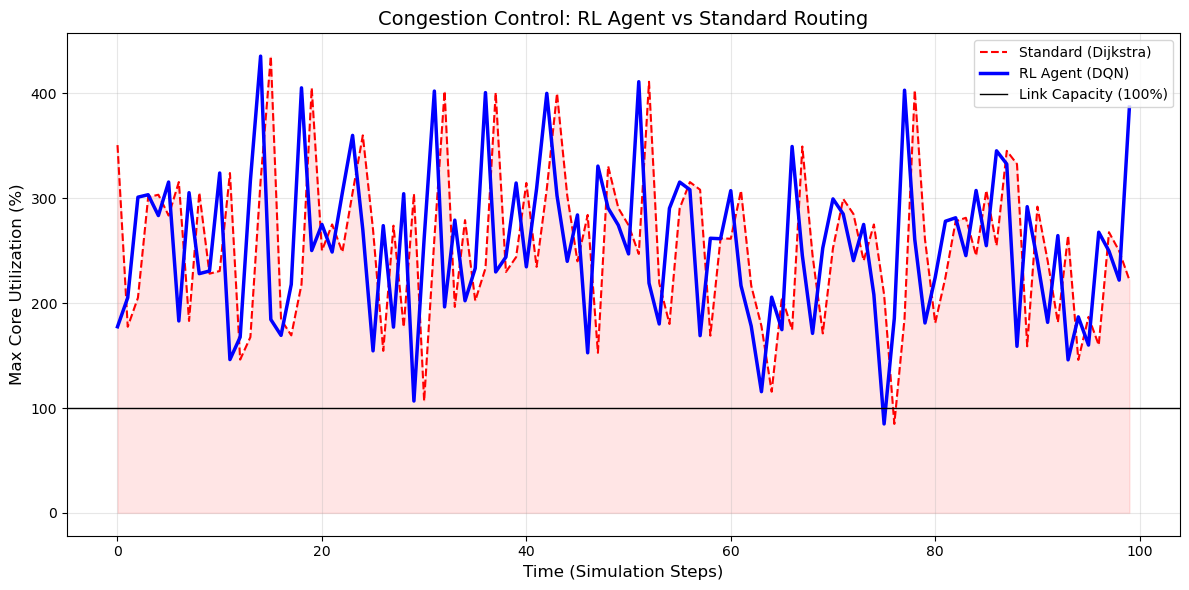

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- CONFIGURATION ---
TEST_DURATION = 100  # Longer test to see stability
TRAFFIC_FILE = "Dataset/Synthesis/synthetic_traffic_16hosts_SPARSE.csv"
MODEL_PATH = "models/dqn_traffic_agent_v2.pth"

print("⚔️ STARTING FINAL BATTLE: Trained Agent vs. Standard Dijkstra...")

# --- 1. SETUP THE ARENA ---
# We use the existing classes you defined
# Make sure imports are correct
import RYU_ENV as env_module
mock_controller = env_module.MockRyuController(TRAFFIC_FILE)
env = NetworkEnv(mock_controller)

# Load the Trained Brain
trained_agent = DQNAgent(state_dim=env.state_dim, action_dim=env.action_dim)
try:
    trained_agent.load_state_dict(torch.load(MODEL_PATH))
    trained_agent.epsilon = 0.0 # 🚨 CRITICAL: Turn off randomness
    trained_agent.eval()
    print("✅ Loaded Trained Model.")
except FileNotFoundError:
    print("❌ Error: Model not found. Please train it first!")
    exit()

# --- 2. DEFINE THE RUNNERS ---

def run_standard_algorithm():
    """
    Simulates Standard Routing (Dijkstra / ECMP).
    The Agent does NOTHING. Traffic follows the default hash logic.
    """
    print("   🛣️  Running Standard Dijkstra (Baseline)...")
    env.mock.time_step = 0 
    env.mock._reset_stats()
    env.mock.flow_table = {} # Clear any old rules
    
    congestion_history = []
    
    for step in range(TEST_DURATION):
        # 1. Physics Engine (Get Stats)
        util, _ = env.mock.get_stats()
        
        # 2. Record Performance (Max Core Link Load)
        # We check Core Switches 1-4 (Index 1-4 in util)
        # Port 1 is the main downlink
        core_loads = [util[c][1] for c in range(1, 5)]
        max_load = max(core_loads) * 100 # Convert to %
        congestion_history.append(max_load)
        
        # 3. Tick Clock (No Action Taken)
        env.mock.tick()
        
    return congestion_history

def run_smart_agent():
    """
    Simulates the RL Agent.
    The Agent actively modifies flow tables to reduce congestion.
    """
    print("   🧠 Running RL Agent (Smart)...")
    env.mock.time_step = 0 
    env.mock._reset_stats()
    env.mock.flow_table = {} # Clear any old rules
    
    state = env.get_state()
    congestion_history = []
    
    for step in range(TEST_DURATION):
        # 1. AI Makes Decision
        action = trained_agent.select_action(state)
        
        # 2. Apply Decision (Reroute Traffic)
        next_state, _, _ = env.step(action)
        
        # 3. Record Performance
        # We check Core Switches 1-4
        util, _ = env.mock.get_stats()
        core_loads = [util[c][1] for c in range(1, 5)]
        max_load = max(core_loads) * 100
        congestion_history.append(max_load)
        
        state = next_state
        
    return congestion_history

# --- 3. RUN THE RACE ---
history_dijkstra = run_standard_algorithm()
history_rl = run_smart_agent()

# --- 4. THE VERDICT (Visual Proof) ---
print("\n📊 FINAL REPORT:")
avg_base = np.mean(history_dijkstra)
avg_smart = np.mean(history_rl)
peak_base = np.max(history_dijkstra)
peak_smart = np.max(history_rl)

improvement = ((avg_base - avg_smart) / avg_base) * 100

print(f"   Avg Load (Dijkstra): {avg_base:.1f}%")
print(f"   Avg Load (RL Agent): {avg_smart:.1f}%")
print(f"   ---------------------------")
print(f"   Peak Load (Dijkstra): {peak_base:.1f}%")
print(f"   Peak Load (RL Agent): {peak_smart:.1f}%")
print(f"   ---------------------------")
print(f"   🚀 EFFICIENCY GAIN: {improvement:.1f}%")

# Plotting
plt.figure(figsize=(12, 6))

# Plot Baseline (Red Area)
plt.fill_between(range(TEST_DURATION), history_dijkstra, color='red', alpha=0.1)
plt.plot(history_dijkstra, color='red', linestyle='--', linewidth=1.5, label="Standard (Dijkstra)")

# Plot AI (Blue Line)
plt.plot(history_rl, color='blue', linewidth=2.5, label="RL Agent (DQN)")

plt.axhline(y=100, color='black', linestyle='-', linewidth=1, label="Link Capacity (100%)")

plt.title(f"Congestion Control: RL Agent vs Standard Routing", fontsize=14)
plt.ylabel("Max Core Utilization (%)", fontsize=12)
plt.xlabel("Time (Simulation Steps)", fontsize=12)
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()